# Jupyter Notebook for BigQuery

In [1]:
import os
import google.cloud.bigquery
import pandas as pd

# define the project and database
PROJECT = os.getenv('GOOGLE_PROJECT_NAME')
DATASET = 'mta_data'

### Set the API client and project information

In [2]:
# using the bigquery client library 
client = google.cloud.bigquery.Client()

# set a reference to the database
dataset_ref = client.dataset(DATASET, project=PROJECT)

# define a run query function
def run_query(sql):
    query = client.query(sql)
    return query.to_dataframe()
    

### View the data that is available on the datalake by querying the external table.

In [3]:
# list the records from the external table (from the data lake)
sql = """
SELECT CA,UNIT,STATION,LINENAME,DIVISION,DATE,TIME,`DESC`,ENTRIES,EXITS 
FROM `{}.{}.ext_turnstile`  
limit 100
""".format(PROJECT, DATASET)
# query the data using the client reference
df = run_query(sql)
print(sql)
df.head(15)



SELECT CA,UNIT,STATION,LINENAME,DIVISION,DATE,TIME,`DESC`,ENTRIES,EXITS 
FROM `ozkary-de-101.mta_data.ext_turnstile`  
limit 100



,CA,UNIT,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,59 ST,NQR456W,BMT,2024-09-28,00:00:00,RECOVR AUD,216611,166467
1,A002,R051,59 ST,NQR456W,BMT,2024-09-28,04:00:00,RECOVR AUD,216622,166475
2,A002,R051,59 ST,NQR456W,BMT,2024-09-28,08:00:00,RECOVR AUD,216625,166500
3,A002,R051,59 ST,NQR456W,BMT,2024-09-28,12:00:00,RECOVR AUD,216650,166582
4,A002,R051,59 ST,NQR456W,BMT,2024-09-28,16:00:00,RECOVR AUD,216728,166640
5,A002,R051,59 ST,NQR456W,BMT,2024-09-28,20:00:00,RECOVR AUD,216801,166678
6,A002,R051,59 ST,NQR456W,BMT,2024-09-29,00:00:00,RECOVR AUD,216843,166702
7,A002,R051,59 ST,NQR456W,BMT,2024-09-29,04:00:00,RECOVR AUD,216848,166708
8,A002,R051,59 ST,NQR456W,BMT,2024-09-29,08:00:00,RECOVR AUD,216853,166718
9,A002,R051,59 ST,NQR456W,BMT,2024-09-29,12:00:00,RECOVR AUD,216870,166773


In [4]:
# get the last date processed
sql = """
SELECT MAX(DATE) as LAST_DATE 
FROM `{}.{}.ext_turnstile`
WHERE station NOT LIKE '%Test%'
""".format(PROJECT, DATASET)
# query the data using the client reference
df = run_query(sql)
print(sql)
df.head(50)


SELECT MAX(DATE) as LAST_DATE 
FROM `ozkary-de-101.mta_data.ext_turnstile`
WHERE station NOT LIKE '%Test%'



,LAST_DATE
0,2024-10-25


### List the database objects

In [6]:
# using the bigquery client library read a list of tables 
tables = list(client.list_tables(dataset_ref))
for table in tables:
    print(table.table_id)

dim_booth
dim_date
dim_station
ext_batch_turnstile
ext_streaming_turnstile
ext_turnstile
fact_stats
fact_turnstile
remote_booth_station
rpt_turnstile
stg_booth
stg_date
stg_station
stg_turnstile


In [7]:
# get the tables in the system and for each table get the schema
# and print the table name and row count
# for table in tables:
#     table_ref = dataset_ref.table(table.table_id)
#     table = client.get_table(table_ref)
#     print(table.schema)

# for each table get the row count
for table in tables:
    table_ref = dataset_ref.table(table.table_id)
    table = client.get_table(table_ref)
    print(table.table_id, table.num_rows)

dim_booth 801
dim_date 5480
dim_station 586
ext_batch_turnstile 0
ext_streaming_turnstile 0
ext_turnstile 0
fact_stats 3
fact_turnstile 5301035
remote_booth_station 768
rpt_turnstile 0
stg_booth 0
stg_date 0
stg_station 0
stg_turnstile 0


### Look at the station information


In [9]:
# read the station information
sql = """
SELECT station_id, station_name
FROM `{}.{}.dim_station`
limit 100
""".format(PROJECT, DATASET)
# query the data using the client reference
df = run_query(sql)
print(sql)
df.head()


SELECT station_id, station_name
FROM `ozkary-de-101.mta_data.dim_station`
limit 100



,station_id,station_name
0,9440f03bc95426dfed0df95d0768ebd2,BEACH 36 ST
1,2e022c4b53de34527d1a8eb5ec5f234b,MYRTLE-WILLOUGH
2,1637671c86de22714149d58244698394,LACKAWANNA
3,46d6cde2d4010f5a20dd0b3dcd8d86d7,W 4 ST-WASH SQ
4,821cb20abd9ee7e5a1358100794c0878,CLINTON-WASH AV


In [13]:
# use sql to query the latest date in the fact_turnstile table and print the result using the client reference
sql = """
SELECT max(created_dt) as max_date
FROM `{}.{}.fact_turnstile`
""".format(PROJECT, DATASET)
# query the data using the client reference
df = run_query(sql)
print(sql)
df.head()


SELECT max(created_dt) as max_date
FROM `ozkary-de-101.mta_data.fact_turnstile`



,max_date
0,2024-10-25 23:56:41+00:00


In [16]:
# read records from n days ago
from datetime import datetime, timedelta

# set a variable to the current date - n days
last_month = datetime.today() - timedelta(days=115)
date_value = last_month.strftime('%Y-%m-%d')

# select a limit of 100 rows with the latest date
sql = """
SELECT station_id, created_dt, entries, exits
FROM `{}.{}.fact_turnstile`
WHERE created_dt >= '{}'
LIMIT 100
""".format(PROJECT, DATASET, date_value)    
print(sql)
df = run_query(sql)
df.head()


SELECT station_id, created_dt, entries, exits
FROM `ozkary-de-101.mta_data.fact_turnstile`
WHERE created_dt >= '2024-08-02'
LIMIT 100



,station_id,created_dt,entries,exits
0,77792700f8184bbf78ed91567285bd1d,2024-10-06 20:00:00+00:00,7204370,13114094
1,77792700f8184bbf78ed91567285bd1d,2024-10-06 00:00:00+00:00,7204213,13113787
2,77792700f8184bbf78ed91567285bd1d,2024-10-06 16:00:00+00:00,7204339,13113952
3,77792700f8184bbf78ed91567285bd1d,2024-10-06 08:00:00+00:00,7204229,13113840
4,77792700f8184bbf78ed91567285bd1d,2024-10-06 12:00:00+00:00,7204287,13113882


In [19]:
# join the fact_turnstile table with the dim_station table and dim_booth table for the last three months

sql = """
SELECT station_name, booth_name, created_dt, entries, exits
FROM `{}.{}.fact_turnstile` as f
JOIN `{}.{}.dim_station` as s
ON f.station_id = s.station_id
JOIN `{}.{}.dim_booth` as b
ON f.booth_id = b.booth_id
WHERE created_dt >= '{}'
LIMIT 1000
""".format(PROJECT, DATASET, PROJECT, DATASET, PROJECT, DATASET, date_value)
df_station = run_query(sql)
print(sql)
print_df(df_station)




SELECT station_name, booth_name, created_dt, entries, exits
FROM `ozkary-de-101.mta_data.fact_turnstile` as f
JOIN `ozkary-de-101.mta_data.dim_station` as s
ON f.station_id = s.station_id
JOIN `ozkary-de-101.mta_data.dim_booth` as b
ON f.booth_id = b.booth_id
WHERE created_dt >= '2024-08-02'
LIMIT 1000



,station_name,booth_name,created_dt,entries,exits
0,ALLERTON AV,R329,2024-10-25 09:00:00+00:00,330533,327522
1,ALLERTON AV,R329,2024-10-25 13:00:00+00:00,330658,327729
2,ALLERTON AV,R329,2024-10-25 01:00:00+00:00,330270,327350
3,ALLERTON AV,R329,2024-10-25 05:00:00+00:00,330296,327372
4,ALLERTON AV,R329,2024-10-25 21:00:00+00:00,330873,328280


## Get the top n stations with the most entries using the df_station dataframe

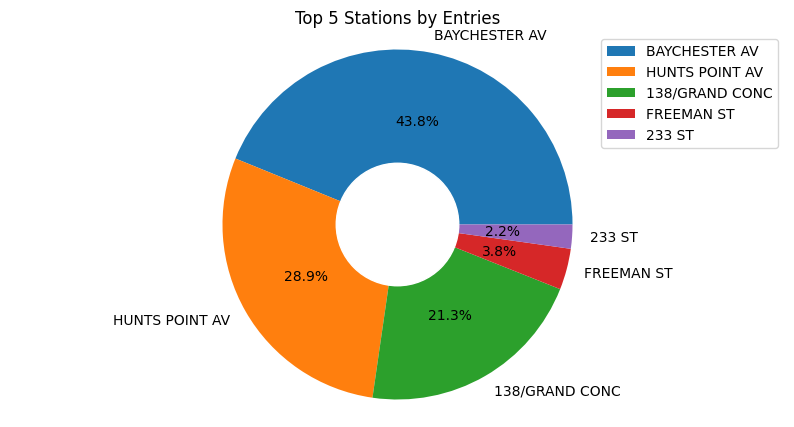

In [20]:

# get the top n stations with the most entries using the df_station dataframe
df_top_entries = df_station.groupby('station_name')['entries'].sum().reset_index().sort_values(by='entries', ascending=False).head(5)

# create a pie chart using the df_top_entries dataframe 
import matplotlib.pyplot as plt

# set the size of the pie chart
plt.figure(figsize=(10,5))

plt.pie(df_top_entries['entries'], labels=df_top_entries['station_name'], autopct='%1.1f%%')
plt.axis('equal')

# add a donut hole to the pie chart
my_circle=plt.Circle( (0,0), 0.35, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)


# add a title and legend to the pie chart
plt.title('Top 5 Stations by Entries')
plt.legend(df_top_entries['station_name'], loc='upper right')

plt.show()

